In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/assignment1


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

kNN分类器由两个阶段组成：
在训练过程中，分类器获取训练数据并简单地记住它
在测试过程中，kNN通过比较所有训练图像并转移k个最相似训练示例的标签来对每个测试图像进行分类
k的值经过交叉验证
在本练习中，您将实施这些步骤，了解基本的图像分类管道、交叉验证，并熟练编写高效的矢量化代码。nd不进行进一步处理

In [ ]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


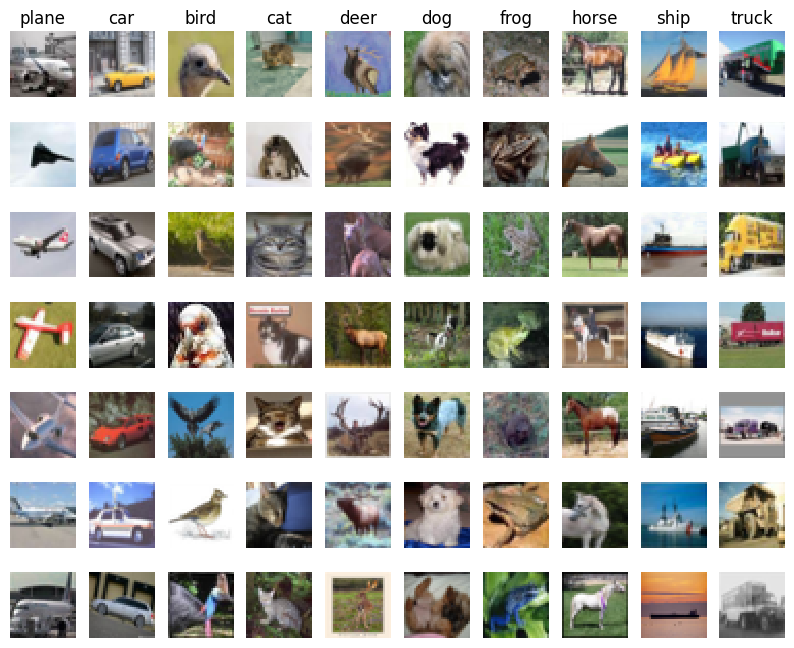

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from cs231n.classifiers import KNearestNeighbor

# 创建一个kNN分类器实例。
#记住，训练kNN分类器是不可能的：
#分类器仅记忆数据，不进行进一步处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

我们现在想用kNN分类器对测试数据进行分类。回想一下，我们可以将这个过程分为两个步骤：

首先，我们必须计算所有测试示例和所有训练示例之间的距离。
给定这些距离，对于每个测试示例，我们找到k个最近的示例，并让它们投票给标签
让我们从计算所有训练和测试示例之间的距离矩阵开始。例如，如果有Ntr个训练示例和Nte个测试示例，则此阶段应产生Nte x Ntr矩阵，其中每个元素（i，j）是第i个测试和第j个训练示例之间的距离。

注意：对于我们要求您在本笔记本中实现的三个距离计算，您可能无法使用numpy提供的np.linalg.norm（）函数。

首先，打开cs231n/classifiers/k_nearest_neighbor.py，并实现函数compute_distances_two_loops，该函数在所有（测试、训练）示例对上使用（非常低效）双环，并一次计算一个元素的距离矩阵。

In [27]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


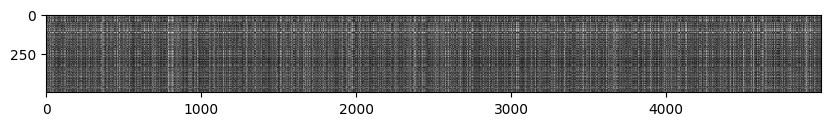

In [26]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

请注意距离矩阵中的结构化图案，其中一些行或列明显更亮。（请注意，在默认配色方案中，黑色表示低距离，白色表示高距离。）

数据中明显明亮的行背后的原因是什么？
是什么导致了这些列？一次一个元素。

$\color{blue}{\textit Your Answer:}$ *fill this in.*

我认为可能是其中出现的异常值 部分图像边缘颜色较深 而白色较少 导致出现较大的差异 因此导致了白色列的出现

In [ ]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

**内联问题2**

我们还可以使用其他距离度量，如L1距离。
对于某个图像$i_k$的位置$（i，j）$处的像素值$p_{ij}^{（k）}$，

所有图像上所有像素的平均$\mu$为$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{1}^{h}\sum_{j=1}^{w}p_{ij}^{（k）}$$
所有图像的像素平均值$\mu_{ij}$为
$$\mu{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{（k）}$$
一般标准偏差$\sigma$和逐像素标准偏差$\sigma_{ij}$的定义类似。

以下哪个预处理步骤不会改变使用L1距离的最近邻分类器的性能？选择所有适用项。为了澄清，训练和测试示例都以相同的方式进行预处理。

1.减去平均值$\mu$（$\tilde{p}_{ij}^{（k）}=p_{ij}^{（k）}-\mu$。）
2.减去每个像素的平均值$\mu_{ij}$（$\tilde{p}_{ij}^{（k）}=p_{ij}^{（k）}-\mu_{ij}$。）
3.减去平均值$\mu$，除以标准偏差$\sigma$。
4.减去像素平均值$\mu_{ij}$，除以像素标准偏差$\sigma_{ij}$。
5.旋转数据的坐标轴，这意味着将所有图像旋转相同的角度。图像中由旋转引起的空白区域用相同的像素值填充，不进行插值。

$\color{blue}{\textit您的答案：}$1 3 5


$\color{blue}{\textit您的解释：}$ 1 3都是对整体的加减乘除 没有影响 而2会导致 黑的变黑 白的变白 4也一样 而5旋转自然没有影响


$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$


In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

#为了确保我们的矢量化实现是正确的，我们确保它
#同意天真的实施。有很多方法可以决定是否
#两个矩阵是相似的；其中最简单的一个是Frobenius范数。万一
#你以前没见过，两个矩阵的Frobenius范数是平方
#所有元素差的平方和的根；换句话说，重塑
#将矩阵转换为向量，并计算它们之间的欧几里德距离。
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.
#使用完全矢量化的实现，您应该会看到明显更快的性能！

#注意：根据您使用的机器，
#当你从两个循环转到一个循环时，你可能看不到加速，
#甚至可能会看到减速。

Two loop version took 0.105965 seconds
One loop version took 0.003134 seconds
No loop version took 0.003012 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

我们已经实现了k-Nearest Neighbor分类器，但我们任意设置了k=5的值。我们现在将通过交叉验证确定此超参数的最佳值。

In [23]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
#待办事项：#
#将训练数据拆分为若干部分。分裂后，X_train_folds和#
#y_train_folds每个都应该是长度为num_folds的列表，其中#
#y_train_folds[i]是X_train_folds[i]中各点的标签向量#
#提示：查找numpy array_split函数。                        #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#一个字典，包含我们发现的不同k值的精度
#运行交叉验证时。在运行交叉验证之后，
#k_to_accuracies[k]应该是一个长度为num_folds的列表，给出不同的
#我们使用k值时发现的精度值。
k_to_accuracies = {}


################################################################################
 #待办事项：#
#执行k倍交叉验证以找到k的最佳值#
#k的可能值，运行k近邻算法num_folds次#
#在每种情况下，您都将除一个折叠外的所有折叠用作训练数据#
#最后一次折叠作为验证集。存储所有折叠和所有折叠的精度#
#ktoaccuracies字典中的k值。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for k in k_choices:
  acc_list=[]
  for i in range(num_folds):
    X_train_folds_train=[]
    y_train_folds_train=[]
    for j in range(num_folds):
      if(j!=i):
        X_train_folds_train.append(X_train_folds[j])
        y_train_folds_train.append(y_train_folds[j])
    X_train_folds_train=np.concatenate(X_train_folds_train)
    y_train_folds_train=np.concatenate(y_train_folds_train)
    X_train_folds_test=X_train_folds[i]
    y_train_folds_test=y_train_folds[i]
    knn=KNearestNeighbor()
    knn.train(X_train_folds_train, y_train_folds_train)
    y_pred=knn.predict(X_train_folds_test,k)
    acc=np.mean(y_pred==y_train_folds_test)
    acc_list.append(acc)
  k_to_accuracies[k]=acc_list
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

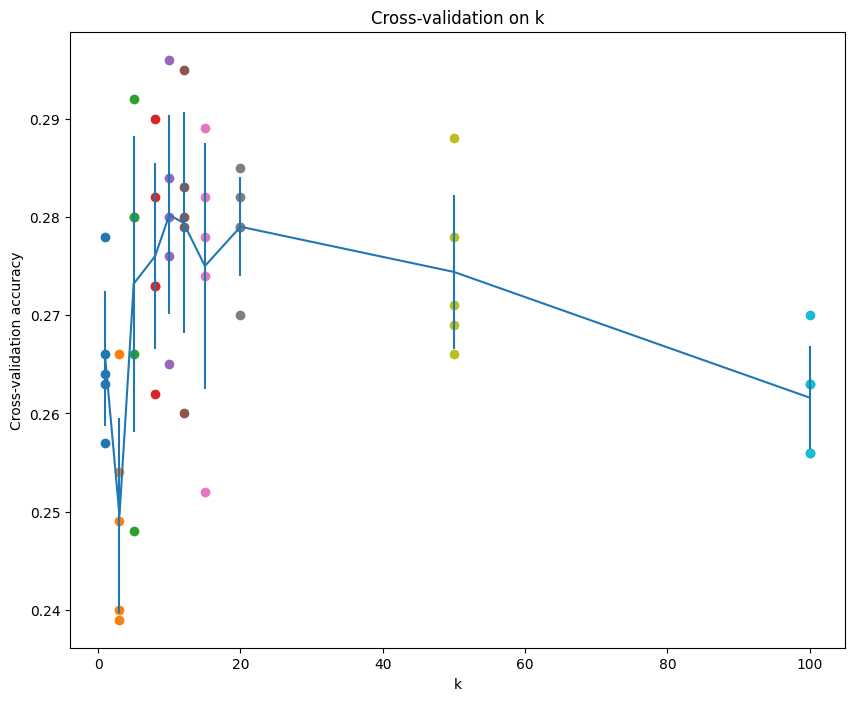

In [24]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [25]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
#基于上述交叉验证结果，选择k的最佳值，
#使用所有训练数据重新训练分类器，并在测试中对其进行测试
#数据。您应该能够在测试数据上获得28%以上的准确率。
best_k=1
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

内联问题3

以下关于k-Nearest Neighbor（k-NN）的哪些陈述在分类设置中是正确的，并且对所有k都是正确的？选择所有适用项。

k-NN分类器的决策边界是线性的。
1-NN的训练误差将始终小于或等于5-NN的训练错误。
1-NN的测试误差总是低于5-NN。
使用k-NN分类器对测试示例进行分类所需的时间随着训练集的大小而增长。
以上都没有。

$\color{blue}{\textit Your Answer:}$1 4


$\color{blue}{\textit Your Explanation:}$1局部都是线性 4时间自然会增加

